<a href="https://colab.research.google.com/github/JericCantos/DisasterTweetPredictions/blob/main/notebooks/DisasterTweetPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project I aim to train and evaluate various models towards the task of classifying whether or not a tweet pertains to a disaster.

We begin by preprocessing the dataset, which involves:
1. Fixing encoding issues
2. Removing punctuation marks, digits, and URLs
3. Removing common english stop words
4. Tokenizing and lemmatizing the words

Given the imbalance between disaster- and non-disaster-tagged tweets, we stratify our train-test split. We also ultimately evaluate the models based on their F1-score.

Hyperparameters for each model and for the TF-IDF Vectorizer are tuned through grid search with crossvalidation.

After training the models on the dataset, common, high-frequency words between disaster- and non-disaster-tagged tweets were identified and removed to see if it will affect model performance.

# Conclusion

## Model Performance

The Multinomial Naive Bayes variant optimized for ROC-AUC trained on a dataset with the common words removed achieved the best F1 score on the test set.

Due to the extremely long runtimes, XGBoost was trained with almost default hyperparameters (only n_estimators had two options), which may contribute to why all XGBoost variants performed worse overall.

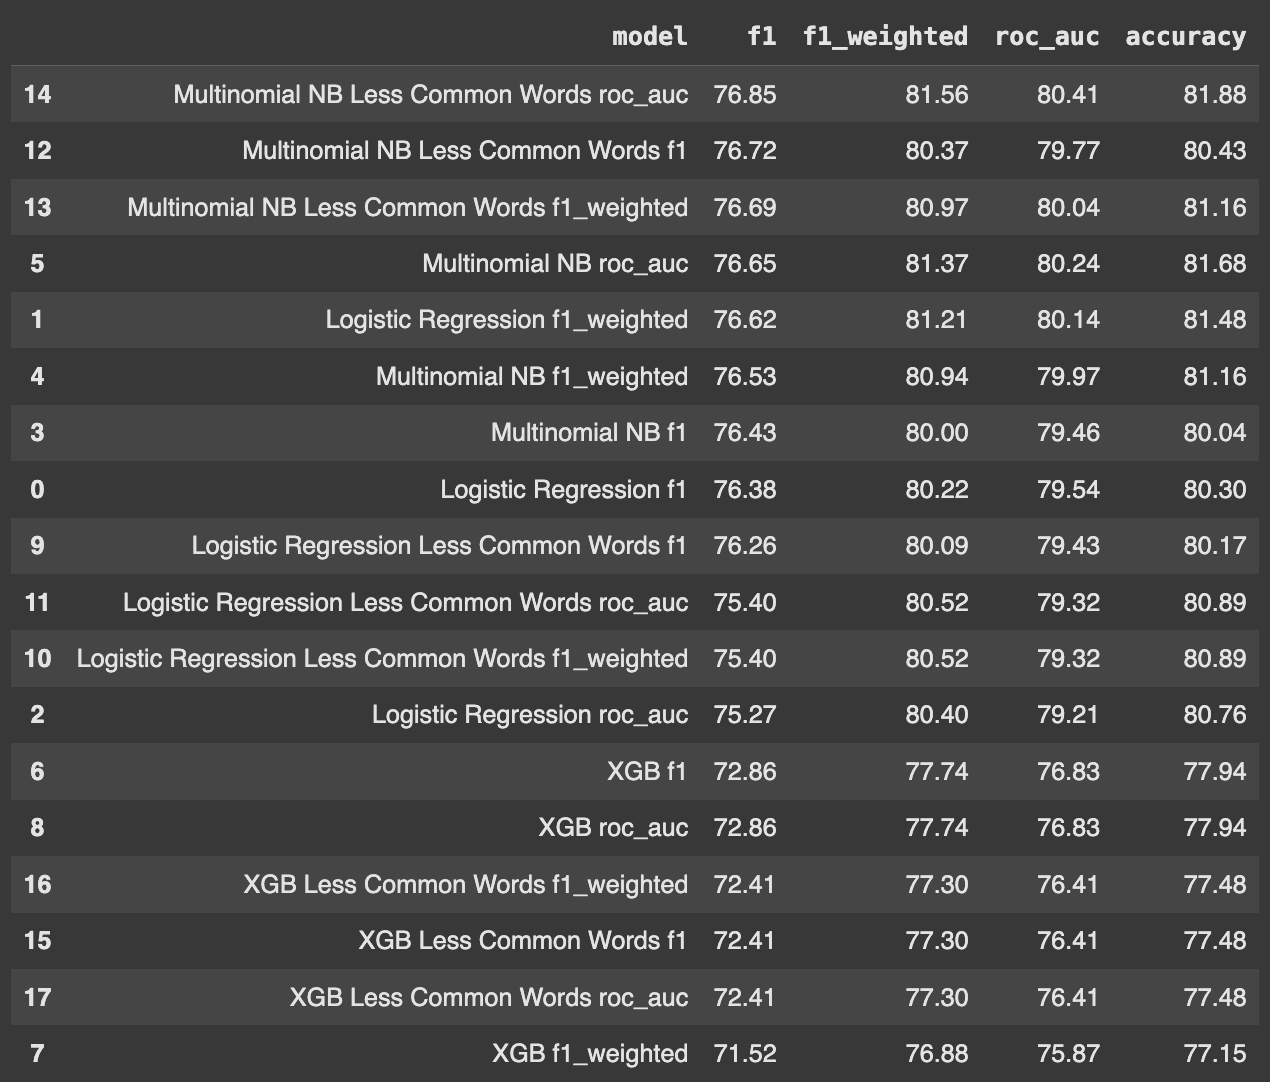

## False Predictions

With a very surface exploration of the false predictions, it is interesting to note that a number of False Negatives seem to be mislabeled (i.e. labeled as a disaster when they are actually not). It would be interesting to see how the classifiers perform if the test dataset was manually corrected to address these false labels.

On the other hand, many false positives carry words that one would associate with disasters, but phrased either as a joke or a theoretical situation. Logistic regression was not properly able to infer context or intent in these cases.

# Setup

## Load Libraries

In [ ]:
!pip install ftfy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 1.4 MB/s eta 0:00:00


In [ ]:
import requests
import io
from ftfy import fix_text

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import nltk
import re
from collections import Counter

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer # more appropriate for tweets than word_tokenizer
from nltk.corpus import wordnet

# Downloading necessary NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')  # List of common stop words in English
nltk.download('punkt')  # Pre-trained tokenizer models
nltk.download('wordnet')  # WordNet lemmatizer dataset
nltk.download('omw-1.4') # Open Multilingual Wordnet to improve WordNet dataset
nltk.download('averaged_perceptron_tagger')  # Needed for POS tagging
nltk.download('averaged_perceptron_tagger_eng') # Needed for POS tagging

# Libraries for text feature extraction and model training
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

# Libraries for model evaluation
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.model_selection import KFold, cross_val_score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


## Load Dataset

In [ ]:
# Build the direct download URL from a file ID
def make_drive_url(file_id):
    return f"https://drive.google.com/uc?id={file_id}"

# Helper function to load a CSV from a direct URL
def load_csv_from_url(url):
    response = requests.get(url)
    response.raise_for_status()  # Raises an error if the request fails
    return pd.read_csv(io.StringIO(response.text))
    # Decode as UTF-8 manually, not using response.text
    #decoded_content = response.content.decode('utf-8', errors='replace')
    #return pd.read_csv(io.StringIO(decoded_content))

In [ ]:
file_ids = {
    "train": "1a8kB3M_-ZTQFJemnNY_g9M3d6yIoJERL",
}

# train: https://drive.google.com/file/d/1a8kB3M_-ZTQFJemnNY_g9M3d6yIoJERL/view?usp=drive_link

In [ ]:
df_train = load_csv_from_url(make_drive_url(file_ids["train"]))

### Fix Double Encoding Errors

In [ ]:
# Fix encoding of all tweets to avoid words like "America\x89Ûªs"
df_train['text'] = df_train['text'].apply(fix_text)

In [ ]:
def fix_double_encoding(text):
    try:
        return text.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        return text


In [ ]:
df_train['text'] = df_train['text'].apply(lambda t: fix_double_encoding(fix_text(t)))

In [ ]:
def repair_text(s):
    if not isinstance(s, str):
        return s
    try:
        # step 1: encode the visible garbage characters as if they were latin1 bytes
        # step 2: decode them back as UTF-8
        s_fixed = s.encode('cp1252', errors='ignore').decode('utf-8', errors='ignore')
        return s_fixed
    except Exception:
        return s


In [ ]:
df_train['text'] = df_train['text'].apply(repair_text)

In [ ]:
df_train.head(20)

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
5,#RockyFire Update => California Hwy. 20 closed...,1
6,#flood #disaster Heavy rain causes flash flood...,1
7,I'm on top of the hill and I can see a fire in...,1
8,There's an emergency evacuation happening now ...,1
9,I'm afraid that the tornado is coming to our a...,1


# Data Preprocessing

In [ ]:
# Function to map NLTK POS tags to WordNet POS tags
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

In [ ]:
def fix_encoding(text):
    try:
        # Encode as latin1 and decode as utf-8 to reverse mojibake
        return text.encode('latin1').decode('utf-8')
    except (UnicodeEncodeError, UnicodeDecodeError):
        # If it fails, return original
        return text

In [ ]:
# Define the preprocessing function
def preprocess_text(sentences):
    # Fix encoding of all tweets to avoid words like "America\x89Ûªs"
    sentences = [fix_encoding(sentence) for sentence in sentences]

    # Convert all tokens to lowercase
    sentences = [sentence.lower() for sentence in sentences]

    # Replace Unicode full-width @ with normal @
    sentences = [re.sub(r"＠", "@", sentence) for sentence in sentences]


    # Remove punctuation using regex
    # Keep hashtags and mentions
    sentences = [re.sub(r"[^\w\s'#@]", "", sentence) for sentence in sentences]

    # Remove numbers and URLs starting with http or www
    sentences = [re.sub(r"http\S+|www\S+|\d+", "", sentence)
                  for sentence in sentences]


    # Remove extra whitespace between words
    sentences = [" ".join(sentence.split()) for sentence in sentences]

    # Tokenize sentences into words
    tokenizer = TweetTokenizer(preserve_case=False)
    sentences = [tokenizer.tokenize(sentence) for sentence in sentences]

    # Remove stop words and single-letter wordsd
    stop_words = set(stopwords.words('english'))  # Load English stop words
    filtered_sentences = []
    for sentence in sentences:
        filtered_sentence = [word for word in sentence if
                             word not in stop_words and
                             len(word) > 1]
        filtered_sentences.append(filtered_sentence)


    lemmatized_sentences = []
    lemmatizer = WordNetLemmatizer()
    for sentence in filtered_sentences:
      # Get POS tags for each word
      pos_tags = nltk.pos_tag(sentence)

      # Lemmatize with POS tags
      lemmas = []
      for word, tag in pos_tags:
        wn_pos = get_wordnet_pos(tag)
        lemmas.append(lemmatizer.lemmatize(word, pos=wn_pos))
      lemmatized_sentences.append(lemmas)

    return [' '.join(sentence) for sentence in lemmatized_sentences]

In [ ]:
df_train['cleaned_tweets'] = preprocess_text(df_train['text'])

In [ ]:
df_train['cleaned_tweets'].head(20)

,cleaned_tweets
0,deed reason #earthquake may allah forgive u
1,forest fire near la ronge sask canada
2,resident ask shelter place notify officer evac...
3,people receive #wildfires evacuation order cal...
4,get sent photo ruby #alaska smoke #wildfires p...
5,#rockyfire update california hwy close directi...
6,#flood #disaster heavy rain cause flash flood ...
7,top hill see fire wood
8,there's emergency evacuation happen building a...
9,afraid tornado come area


# Train-Test Split

In [ ]:
df = pd.DataFrame({'text': df_train['cleaned_tweets'],
                   'target': df_train['target']})
df.head()

,text,target
0,deed reason #earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident ask shelter place notify officer evac...,1
3,people receive #wildfires evacuation order cal...,1
4,get sent photo ruby #alaska smoke #wildfires p...,1


In [ ]:
df['target'].value_counts(normalize=True)

,proportion
target,
0,0.57034
1,0.42966


There is a slight imbalance in the dataset (~57% negative, ~43% positive). Stratification is a good idea.

In [ ]:
# Use train_test_split instead so we can stratify the split to maintain balance
X_train, X_test, y_train, y_test = train_test_split(df['text'],
                                                    df['target'],
                                                    test_size=0.2,
                                                    stratify=df['target'],
                                                    random_state=42)

# Print sizes of training and test sets
print("Size of training set:", len(X_train))
print("Size of test set:", len(X_test))

Size of training set: 6090
Size of test set: 1523


# Feature Extraction

In [ ]:
# Use a tweet tokenizer in the TfidVectorizer so it becomes
# aware of mentions and hashtags
tweet_tokenizer = TweetTokenizer(preserve_case=False)

tfidf_vectorizer = TfidfVectorizer(
    tokenizer = tweet_tokenizer.tokenize,
    preprocessor = None,
    token_pattern = None
)

# Transform the training data into a TF-IDF matrix
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
# Transform the test data into a TF-IDF matrix
X_test_tfidf = tfidf_vectorizer.transform(X_test)


# Check the number of samples and features
num_samples, num_features = X_train_tfidf.shape
print("Train #Samples: {}, #Features: {}".format(num_samples, num_features))
num_samples_test, num_features_test = X_test_tfidf.shape
print("Test #Samples: {}, #Features: {}".format(num_samples_test,
                                                num_features_test))

Train #Samples: 6090, #Features: 13646
Test #Samples: 1523, #Features: 13646


In [ ]:
tfidf_vectorizer.get_feature_names_out()

array(['##book', '##fukushima', '##youtube', ..., 'zss', 'zumiez',
       'zurich'], dtype=object)

# Machine Learning Setup

Given the imbalance in the dataset, I would choose F1 score as the ultimate metric for evaluation. However, I will train versions of various models optimizing for f1, f1-weighted, and roc-auc to see which one will give the best F1 score.

## Global Configuration Values

In [ ]:
# Dictionary of Results
model_comparisons = {}

scoring_functions = ['f1', 'f1_weighted', 'roc_auc']

## Helper Functions

In [ ]:
def create_pipeline(model):
  return Pipeline([
    ('tfidf', TfidfVectorizer(
        tokenizer = tweet_tokenizer.tokenize,
        preprocessor = None,
        token_pattern = None
    )),
    ('model', model)
  ])

In [ ]:
def get_param_grid(model):
    # Return an appropriate parameter grid for GridSearchCV,
    # based on the model type.

    # Shared TF-IDF hyperparameters
    base_grid = {
        'tfidf__ngram_range': [(1, 1), (1, 2), (1, 3), (1, 4)],
        'tfidf__max_df': [0.8, 1.0], # ignore too common words
        'tfidf__min_df': [1, 2], # ignore too rare words
    }

    # Model-specific hyperparameters
    if isinstance(model, XGBClassifier):
        model_grid = {
            'model__n_estimators': [100, 500],
            #'model__max_depth': [5, 10],
            #'model__learning_rate': [0.05, 0.1],
            #'model__subsample': [0.7, 1.0],
            #'model__colsample_bytree': [0.7, 1.0],
        }

    elif isinstance(model, LogisticRegression):
        model_grid = {
            'model__C': [0.1, 1, 10],
            'model__solver': ['saga'],
            #'model__penalty': ['l2', 'l1'],  # saga supports both
            'model__max_iter': [100, 200]
        }

    elif isinstance(model, MultinomialNB):
        model_grid = {
            'model__alpha': [0.1, 0.5, 1.0],
            'model__fit_prior': [True, False]
        }

    else:
        raise ValueError(f"Model type {type(model).__name__} not supported.")

    # Merge shared TF-IDF + model-specific parameters
    full_grid = {**base_grid, **model_grid}

    return full_grid

In [ ]:
def train_model(pipeline, X_train_scaled, y_train,
                X_test_scaled, y_test,
                param_grid, ispca, n_components, scoring, cv=5,
                              numeric_features=  ['applicant_income',
                                          'coapplicant_income',
                                          'loan_amount' ]):

  if(ispca):
    print ('Components:', i)
    pca = PCA(n_components=n_components,
                         random_state=42)
    X_train_scaled = pca.fit_transform(X_train_scaled)
    X_test_scaled = pca.transform(X_test_scaled)

  # Set up the GridSearchCV
  grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=cv,
                            scoring=scoring, n_jobs=-1, verbose=1)

  # Fit the grid search model
  grid_search.fit(X_train_scaled, y_train)

  # Best parameters found by Grid Search
  print("Best Hyperparameters:", grid_search.best_params_)

  return (grid_search.best_estimator_,
          X_train_scaled,
          X_test_scaled,
          y_train,
          y_test,
          grid_search.best_params_,
          )

In [ ]:
def evaluate_model (model, X_train, y_train, X_test, y_test, best_params,
                    run_label):
  print(f'-----{run_label}-----')

  train_pred = model.predict(X_train)
  y_pred = model.predict(X_test)

  # evaluate train
  train_accuracy = round(accuracy_score(y_train, train_pred)*100, 2)
  train_conf_matrix = confusion_matrix(y_train, train_pred)
  train_class_report = classification_report(y_train, train_pred)
  train_roc_auc = round(roc_auc_score(y_train, train_pred)*100, 2)
  train_f1 = round(f1_score(y_train, train_pred)*100, 2)
  train_f1_weighted = round(f1_score(y_train, train_pred, average='weighted')*100, 2)

  # evaluate test
  accuracy = round(accuracy_score(y_test, y_pred)*100, 2)
  conf_matrix = confusion_matrix(y_test, y_pred)
  class_report = classification_report(y_test, y_pred)
  roc_auc = round(roc_auc_score(y_test, y_pred)*100, 2)
  f1 = round(f1_score(y_test, y_pred)*100, 2)
  f1_weighted = round(f1_score(y_test, y_pred, average='weighted')*100, 2)

  # Printing evaluation metrics
  print("Training Confusion Matrix:\n", train_conf_matrix)
  print("Testing Confusion Matrix:\n", conf_matrix)
  print("Accuracy: Test", accuracy, ' - ' , train_accuracy, 'Train')
  print("ROC AUC: Test", roc_auc, ' - ' , train_roc_auc, 'Train')
  print("F1-score: Test", f1, ' - ' , train_f1, 'Train')
  print("Weighted F1-score:", f1_weighted, ' - ' , train_f1_weighted, 'Train')

  print("Training Classification Report:\n", train_class_report)
  print("Test Classification Report:\n", class_report)

  #Save the run stats
  model_comparisons[run_label] = {'accuracy': accuracy,
                                  'conf_matrix': conf_matrix,
                                  'class_report': class_report,
                                  'roc_auc' : roc_auc,
                                  'f1' : f1,
                                  'f1_weighted': f1_weighted,
                                  'best_params': best_params,
                                  'model': model}


In [ ]:
def model_summaries (model_list=None):
  df_models = pd.DataFrame.from_dict(model_comparisons, orient='index')
  df_models = df_models[['f1', 'f1_weighted', 'roc_auc', 'accuracy' ]]
  df_models = df_models.reset_index()
  df_models.rename(columns={'index': 'model'}, inplace=True)

  if model_list is None:
    return df_models.sort_values(by='f1', ascending=False)

  return df_models[df_models['model'].isin(model_list)]\
              .sort_values(by='f1', ascending=False)

In [ ]:
def get_false_predictions(model, X_test, y_test):
  y_pred = model.predict(X_test)
  y_true = y_test

  results = pd.DataFrame({
    'text': X_test,
    'true_label': y_true,
    'predicted_label': y_pred
  })

  false_positives = (results[(results.true_label == 0)
                    & (results.predicted_label == 1)])
  false_negatives = (results[(results.true_label == 1)
                    & (results.predicted_label == 0)])

  return false_positives, false_negatives



# Logistic Regression

Logistic regression
optimized for Weighted F1 Score with the following hyperparameters resulted in the best F1-score among the tested variants:

```
Best Hyperparameters: {
    'model__C': 1,
    'model__max_iter': 100,
    'model__solver': 'saga',
    'tfidf__max_df': 0.8,
    'tfidf__min_df': 1,
    'tfidf__ngram_range': (1, 1)
}
```

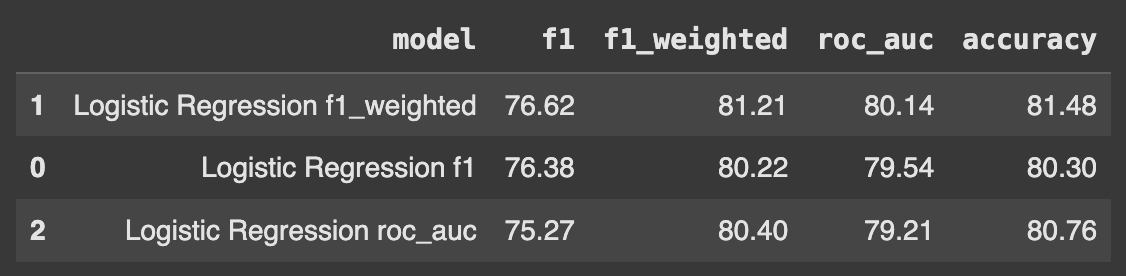

In [ ]:
'''
Scoring Function: f1_weighted
Best Hyperparameters: {
  'model__C': 1,
  'model__max_iter': 100,
  'model__solver': 'saga',
  'tfidf__max_df': 0.8,
  'tfidf__min_df': 2,
  'tfidf__ngram_range': (1, 1)
  }
'''

for scoring in scoring_functions:
  my_X_train = X_train
  my_X_test = X_test
  my_y_train = y_train
  my_y_test = y_test

  model = LogisticRegression(max_iter=10000, random_state=42,)

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'Logistic Regression {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'model__C': 10, 'model__max_iter': 100, 'model__solver': 'saga', 'tfidf__max_df': 0.8, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
-----Logistic Regression f1-----
Training Confusion Matrix:
 [[3447   26]
 [  61 2556]]
Testing Confusion Matrix:
 [[738 131]
 [169 485]]
Accuracy: Test 80.3  -  98.57 Train
ROC AUC: Test 79.54  -  98.46 Train
F1-score: Test 76.38  -  98.33 Train
Weighted F1-score: 80.22  -  98.57 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3473
           1       0.99      0.98      0.98      2617

    accuracy                           0.99      6090
   macro avg       0.99      0.98      0.99      6090
weighted avg       0.99      0.99      0.99      6090

Test Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.85      0.83   

In [ ]:
df_summary = model_summaries(['Logistic Regression f1',
                   'Logistic Regression f1_weighted',
                   'Logistic Regression roc_auc'])

df_summary

,model,f1,f1_weighted,roc_auc,accuracy
1,Logistic Regression f1_weighted,76.62,81.21,80.14,81.48
0,Logistic Regression f1,76.38,80.22,79.54,80.30
2,Logistic Regression roc_auc,75.27,80.40,79.21,80.76


# Multinomial Naive Bayes

Optimizing for ROC_AUC score this time yields the best F1 score on the test dataset among all variants at 76.65.  The best Logistic Regression model came in just slightly under.

```
Best Hyperparameters: {
    'model__alpha': 1.0,
    'model__fit_prior': True,
    'tfidf__max_df': 0.8,
    'tfidf__min_df': 2,
    'tfidf__ngram_range': (1, 1)
}
```

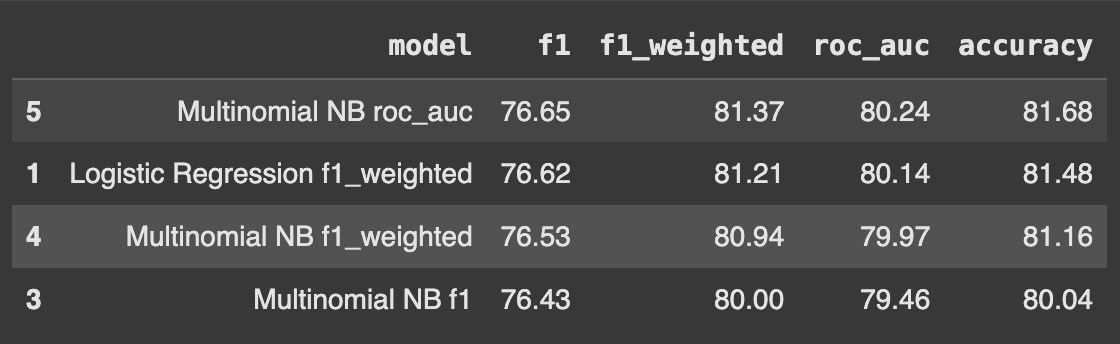

In [ ]:
'''
Scoring Function: ROC_AUC
Best Hyperparameters: {
  'model__alpha': 1.0,
  'model__fit_prior': True,
  'tfidf__max_df': 0.8,
  'tfidf__min_df': 2,
  'tfidf__ngram_range': (1, 1)
}
'''

for scoring in scoring_functions:
  my_X_train = X_train
  my_X_test = X_test
  my_y_train = y_train
  my_y_test = y_test

  model = MultinomialNB()

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'Multinomial NB {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'model__alpha': 1.0, 'model__fit_prior': False, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
-----Multinomial NB f1-----
Training Confusion Matrix:
 [[3135  338]
 [ 494 2123]]
Testing Confusion Matrix:
 [[726 143]
 [161 493]]
Accuracy: Test 80.04  -  86.34 Train
ROC AUC: Test 79.46  -  85.7 Train
F1-score: Test 76.43  -  83.62 Train
Weighted F1-score: 80.0  -  86.28 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.90      0.88      3473
           1       0.86      0.81      0.84      2617

    accuracy                           0.86      6090
   macro avg       0.86      0.86      0.86      6090
weighted avg       0.86      0.86      0.86      6090

Test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83       869
           1   

In [ ]:
df_summary = model_summaries(['Multinomial NB f1',
                   'Multinomial NB f1_weighted',
                   'Multinomial NB roc_auc',
                   'Logistic Regression f1_weighted'])

df_summary

,model,f1,f1_weighted,roc_auc,accuracy
5,Multinomial NB roc_auc,76.65,81.37,80.24,81.68
1,Logistic Regression f1_weighted,76.62,81.21,80.14,81.48
4,Multinomial NB f1_weighted,76.53,80.94,79.97,81.16
3,Multinomial NB f1,76.43,80.00,79.46,80.04


# XGBoost Classifier

The XGBoost grid search takes so much time that I was only able to tune the number of estimators alongside the TF-IDF parameters. All XGBoost variants performed worse than Multinomial Naive Bayes and Logistic Regression.

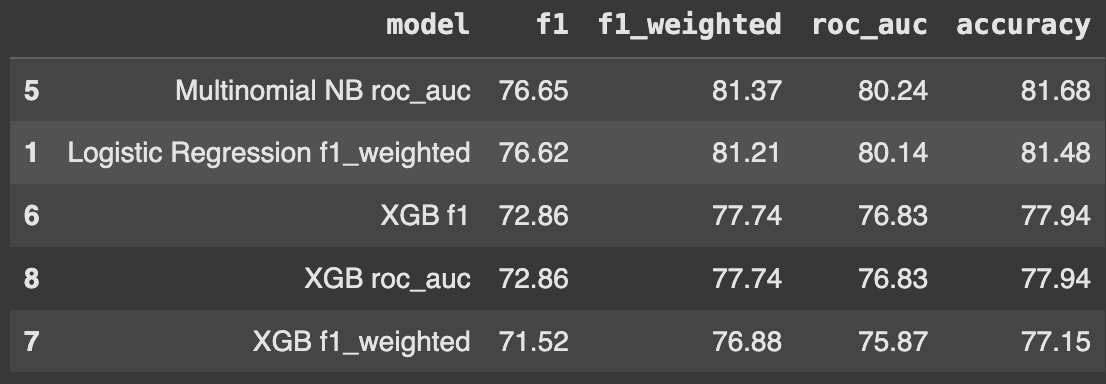

In [ ]:
for scoring in scoring_functions:
  my_X_train = X_train
  my_X_test = X_test
  my_y_train = y_train
  my_y_test = y_test

  model = XGBClassifier()

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'XGB {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'model__n_estimators': 500, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
-----XGB f1-----
Training Confusion Matrix:
 [[3412   61]
 [ 335 2282]]
Testing Confusion Matrix:
 [[736 133]
 [203 451]]
Accuracy: Test 77.94  -  93.5 Train
ROC AUC: Test 76.83  -  92.72 Train
F1-score: Test 72.86  -  92.02 Train
Weighted F1-score: 77.74  -  93.44 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.95      3473
           1       0.97      0.87      0.92      2617

    accuracy                           0.93      6090
   macro avg       0.94      0.93      0.93      6090
weighted avg       0.94      0.93      0.93      6090

Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.85      0.81       869
           1       0.77      0.69      0.73  

In [ ]:
df_summary = model_summaries(['XGB f1',
                   'XGB f1_weighted',
                   'XGB roc_auc',
                   'Multinomial NB roc_auc',
                   'Logistic Regression f1_weighted'])

df_summary

,model,f1,f1_weighted,roc_auc,accuracy
5,Multinomial NB roc_auc,76.65,81.37,80.24,81.68
1,Logistic Regression f1_weighted,76.62,81.21,80.14,81.48
6,XGB f1,72.86,77.74,76.83,77.94
8,XGB roc_auc,72.86,77.74,76.83,77.94
7,XGB f1_weighted,71.52,76.88,75.87,77.15


# False Predictions Exploration

As the performance of Logistic Regression and Multinomial Naive Bayes seem comparable, let's just do a quick exploration of the false predictions done by the best Logistic Regression model.

In [ ]:
model = model_comparisons['Logistic Regression f1_weighted']['model']
false_positives, false_negatives = get_false_predictions(model, X_test, y_test)
print (f'False Positives: {len(false_positives)}')
print (f'False Negatives: {len(false_negatives)}')

False Positives: 90
False Negatives: 192


## False Positives

There are some examples of tweets being tagged as "disaster-related" which were actually talking about fantasies, possibilities, or jokes, but using words that humans may associate with disasters, e.g.:
- if firefighters acted like cops they'd drive around shooting a flamethrower at burning buildings
- I hope it rains throughout the whole weekend I hope it floods and the portaloos become sentient.

A tweet about an earthquate was classified as a disaster even though the event was only moderate, likely because the classifier would not know about magnitudes and we stripped the digits besides:
- #Sismo M 1.3 - 1km NNE of The Geysers California: Time2015-08-05 23:40:21 UTC2015-08-05 16:40:21 -07:00 a... http://t.co/x6el3ySYcn #CS

There are some tweets that even a human might misclassify given that we don't have the proper context, e.g.:
- I See Fire

In [ ]:
for i, tweet in df_train.loc[false_positives.index, 'text'].head(20).items():
    print(f"{i}: {tweet}\n")

1358: if firefighters acted like cops they'd drive around shooting a flamethrower at burning buildings

5267: @TroySlaby22 slicker than an oil spill

1660: Look: #I have collapsed #after attempting to munch an endangered species.

4004: I hope it rains throughout the whole weekend I hope it floods and the portaloos become sentient.

3057: #Sismo M 1.3 - 1km NNE of The Geysers California: Time2015-08-05 23:40:21 UTC2015-08-05 16:40:21 -07:00 a... http://t.co/x6el3ySYcn #CS

2986: Drowning in Actavis suicide

4666: Already expecting to be inundated w/ articles about trad authors' pay plummeting by early next year but if this is true it'll be far worse

3749: I See Fire

4376: Governor weighs parole for California school bus hijacker http://t.co/7NPBfRzEJL http://t.co/Y0kByy8nce

2951: So today I fell off a rock scraped my whole butt and nearly drowned #summer2k15

1823: @johndcgow heard this few days ago while driving and near crashed the car from laughing to much

5899: @SunderCR two ho

## False Negatives

Many items seem to have been mislabeled from the start i.e. labeled as a disaster, which our classifier predicts as not. In fact, in these 20 random tweets, it is easier to list the real "mistakes" than the mislabeled tweets.

--- Disaster tweets predicted as non-disaster ---
- on the flip side I'm at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not
- A subcontractor working for French seismic survey group CGG has been kidnapped in Cairo and is held by Islamic State the company said on W_
- @SwiftyCommissh @TaoistInsight @ImmortalTech Some jewish ppl agree tht Israel is a bully nd a terrorist state killin palestine kids nd women (MAYBE???)

The rest of the tweets are not disasters but are labeled as such.


In [ ]:
for i, tweet in df_train.loc[false_negatives.index, 'text'].head(20).items():
    print(f"{i}: {tweet}\n")

6837: Hollywood Movie About Trapped Miners Released in Chile: 'The 33' Hollywood movie about trapped miners starring... http://t.co/tyyfG4qQvM

2905: I can't drown my demons they know how to swim

1956: @XHNews We need these plants in the pacific during the cyclone seasons it would help

5020: 'It looks like a mudslide' poor thing! ?? #greatbritishbakeoff

7605: on the flip side I'm at Walmart and there is a bomb and everyone had to evacuate so stay tuned if I blow up or not

6818: Bomb head? Explosive decisions dat produced more dead children than dead bodies trapped tween buildings on that day in September there

6006: I agree with certain cultural appropriation things but honestly if u looked at my house it screams appropriation bc Buddhas and stuff-

3441: The Dress Memes Have Officially Exploded On The Internet http://t.co/3drSmxw3cr

6488: Aquarium Ornament Wreck Sailing Boat Sunk Ship Destroyer Fish Tank Cave Decor - Full read _ http://t.co/nosA8JJjiN http://t.co/WUKvdavUJu

564

# Model Tweaking

In [ ]:
disaster_tweets = X_train[y_train == 1]
non_disaster_tweets = X_train[y_train == 0]

disaster_tweets.values

array(['sassy city girl country hunk strand smoky mountain snowstorm #aoms #ibooklove #bookboost',
       'malaysia confirm plane debris wash reunion island flight mh',
       'climate consequence u forest service say spending half budget fire',
       ..., 'hero springer spaniel dog dad rescue stranded baby dolphin',
       'voluntary evacuation recommend time pickerel lake cabin across highway #reidlake fire say maca #nwt #yzf',
       'rt @calestous tanzania elephant population decline five year census reveals'],
      dtype=object)

In [ ]:
def flatten_tweets(tweets):
  return [word for tweet in tweets for word in tweet.split()]

In [ ]:
disaster_tokens = flatten_tweets(disaster_tweets)
non_disaster_tokens = flatten_tweets(non_disaster_tweets)

In [ ]:
disaster_word_counts = Counter(disaster_tokens)
non_disaster_word_counts = Counter(non_disaster_tokens)

In [ ]:
disaster_top_words = disaster_word_counts.most_common(15)
non_disaster_top_words = non_disaster_word_counts.most_common(15)

In [ ]:
disaster_df = pd.DataFrame(disaster_top_words, columns = ['Word','Count'])
disaster_df.head()

,Word,Count
0,fire,217
1,kill,131
2,bomb,114
3,get,99
4,via,95


In [ ]:
non_disaster_df = pd.DataFrame(non_disaster_top_words, columns = ['Word','Count'])
non_disaster_df.head()

,Word,Count
0,get,261
1,like,231
2,go,152
3,new,147
4,make,108


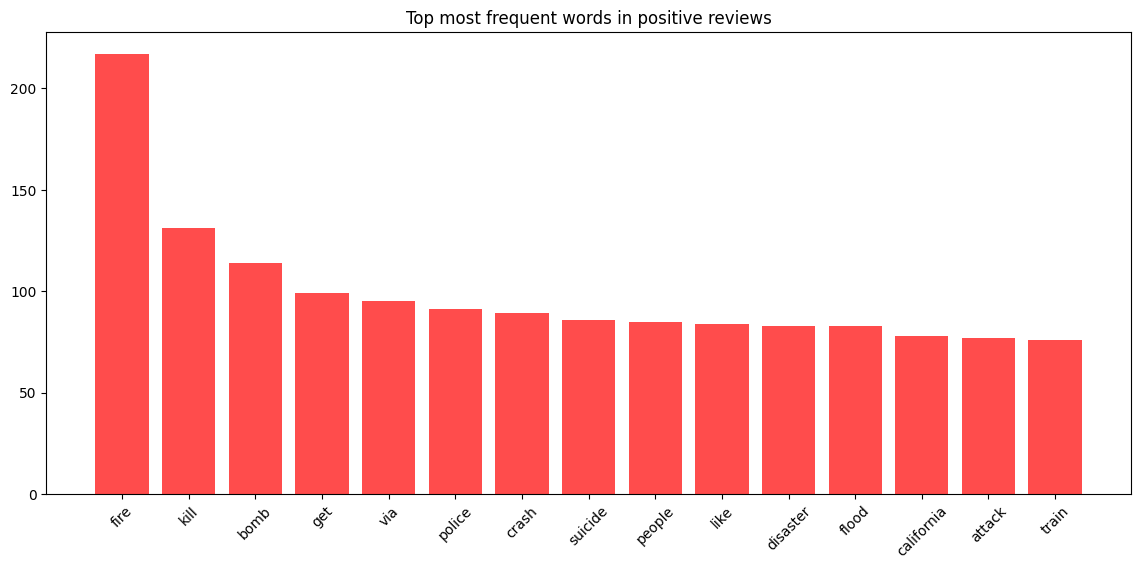

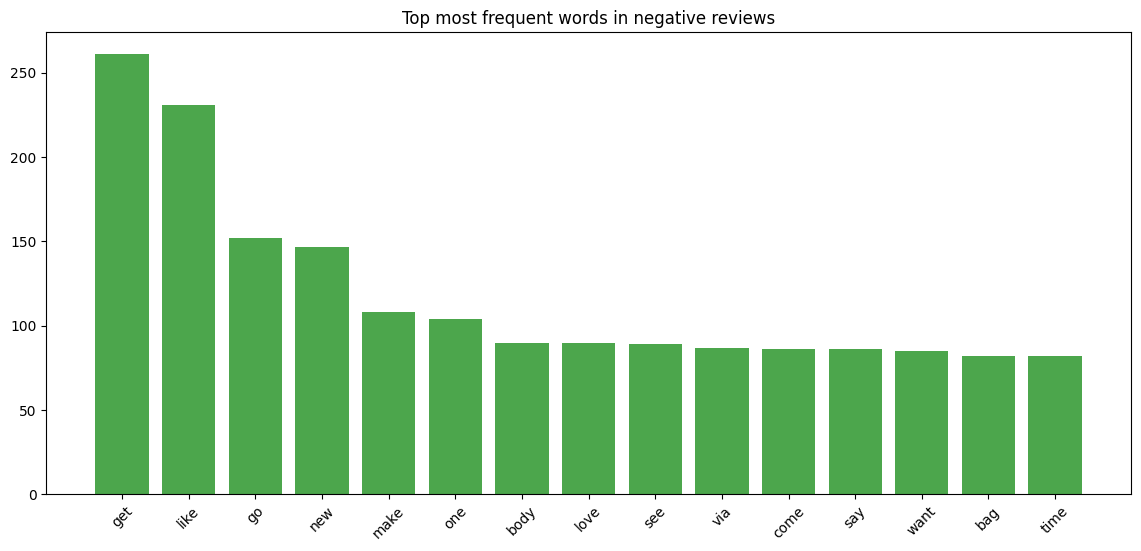

In [ ]:
plt.figure(figsize = (14, 6))
plt.bar(disaster_df['Word'], disaster_df['Count'], color='red', alpha=0.7)
plt.title('Top most frequent words in positive reviews')
plt.xticks(rotation=45)
plt.show()


plt.figure(figsize = (14, 6))
plt.bar(non_disaster_df['Word'], non_disaster_df['Count'], color='green', alpha=0.7)
plt.title('Top most frequent words in negative reviews')
plt.xticks(rotation=45)
plt.show()

In [ ]:
df_common = non_disaster_df[non_disaster_df['Word'].isin(disaster_df['Word'])]
df_common

,Word,Count
0,get,261
1,like,231
9,via,87


Remove `get`, `like`, and `via` from the train and test datasets and then run the models again to see if it results in better predictions.

In [ ]:
common_words = df_common['Word'].values
common_words

array(['get', 'like', 'via'], dtype=object)

In [ ]:
# create a regex pattern that can isolate the common words for removal
pattern = r'\b(' + '|'.join(common_words) + r')\b'

X_train_reduced = X_train.str.replace(pattern, '', regex=True, case=False)
X_test_reduced  = X_test.str.replace(pattern, '', regex=True, case=False)


In [ ]:
X_train_reduced

,text
6234,sassy city girl country hunk strand smoky moun...
326,god's kingdom heavenly gov't rule people earth...
997,mopheme bigstar johnson problem game body bag ...
7269,@vixmeldrew sound whirlwind life
2189,malaysia confirm plane debris wash reunion isl...
...,...
3386,voluntary evacuation recommend time pickerel l...
3280,rt @calestous tanzania elephant population dec...
305,#pbban temporary russaky armageddon kill flag ...
1648,petition heartless owner whip horse collapse t...


In [ ]:
X_test_reduced

,text
4863,@theeconomist step one mass murderer's portra...
1370,ted cruz fire back jeb bush lose republican j...
3521,little boy affect people hiroshima eyewitness ...
178,ambulance sprinter automatic frontline vehicle...
5859,cause play symphony play till finger bleed gr...
...,...
6939,@princeoffencing frickin summer humidity build...
2074,@emmerdale ross really dead #askcharley
3186,bc cost less sick people use emergency roomsgrrrr
4297,@hellfire_ev @jackperu one


## Logistic Regression

The removal of the common words only beat the roc_auc variant of our original implementation.

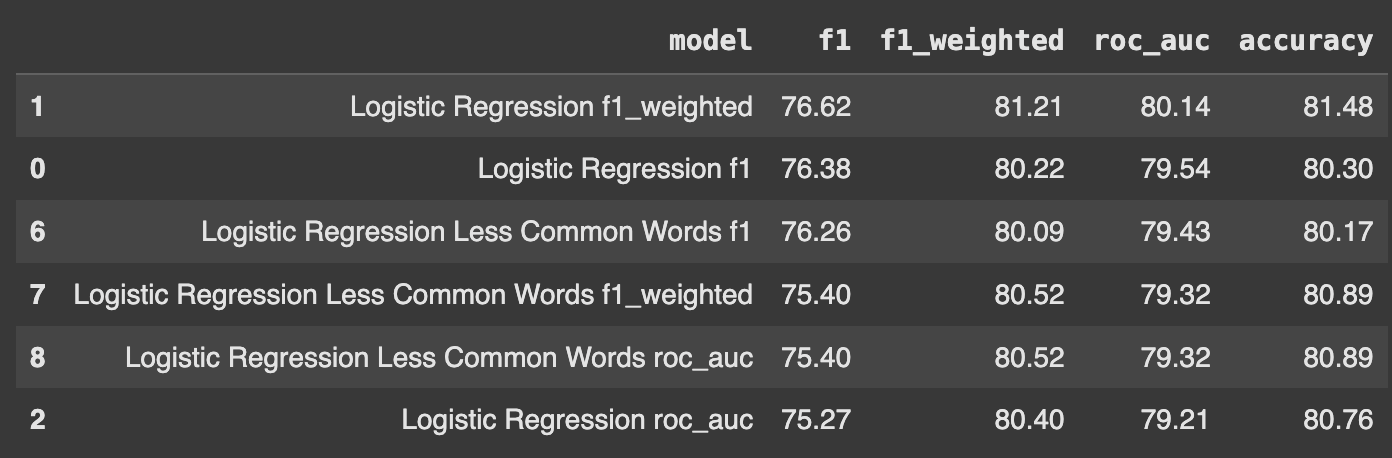

In [ ]:
for scoring in scoring_functions:
  my_X_train = X_train_reduced
  my_X_test = X_test_reduced
  my_y_train = y_train
  my_y_test = y_test

  model = LogisticRegression(max_iter=10000, random_state=42,)

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'Logistic Regression Less Common Words {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'model__C': 10, 'model__max_iter': 100, 'model__solver': 'saga', 'tfidf__max_df': 0.8, 'tfidf__min_df': 1, 'tfidf__ngram_range': (1, 2)}
-----Logistic Regression Less Common Words f1-----
Training Confusion Matrix:
 [[3447   26]
 [  61 2556]]
Testing Confusion Matrix:
 [[736 133]
 [169 485]]
Accuracy: Test 80.17  -  98.57 Train
ROC AUC: Test 79.43  -  98.46 Train
F1-score: Test 76.26  -  98.33 Train
Weighted F1-score: 80.09  -  98.57 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      3473
           1       0.99      0.98      0.98      2617

    accuracy                           0.99      6090
   macro avg       0.99      0.98      0.99      6090
weighted avg       0.99      0.99      0.99      6090

Test Classification Report:
               precision    recall  f1-score   support

           0       0.81    

In [ ]:
df_summary = model_summaries(['Logistic Regression Less Common Words f1',
                   'Logistic Regression Less Common Words f1_weighted',
                   'Logistic Regression Less Common Words roc_auc',
                   'Logistic Regression f1',
                   'Logistic Regression f1_weighted',
                   'Logistic Regression roc_auc'])

df_summary

,model,f1,f1_weighted,roc_auc,accuracy
1,Logistic Regression f1_weighted,76.62,81.21,80.14,81.48
0,Logistic Regression f1,76.38,80.22,79.54,80.30
9,Logistic Regression Less Common Words f1,76.26,80.09,79.43,80.17
10,Logistic Regression Less Common Words f1_weighted,75.40,80.52,79.32,80.89
11,Logistic Regression Less Common Words roc_auc,75.40,80.52,79.32,80.89
2,Logistic Regression roc_auc,75.27,80.40,79.21,80.76


## Multinomial Naive Bayes

Removing the common words has boosted the performance of Multinomial NB, with the variant optimized for ROC_AUC score now having the best F1 score of the bunch.

```
Best Hyperparameters: {
    'model__alpha': 1.0,
    'model__fit_prior': True,
    'tfidf__max_df': 0.8,
    'tfidf__min_df': 2,
    'tfidf__ngram_range': (1, 1)
}
```

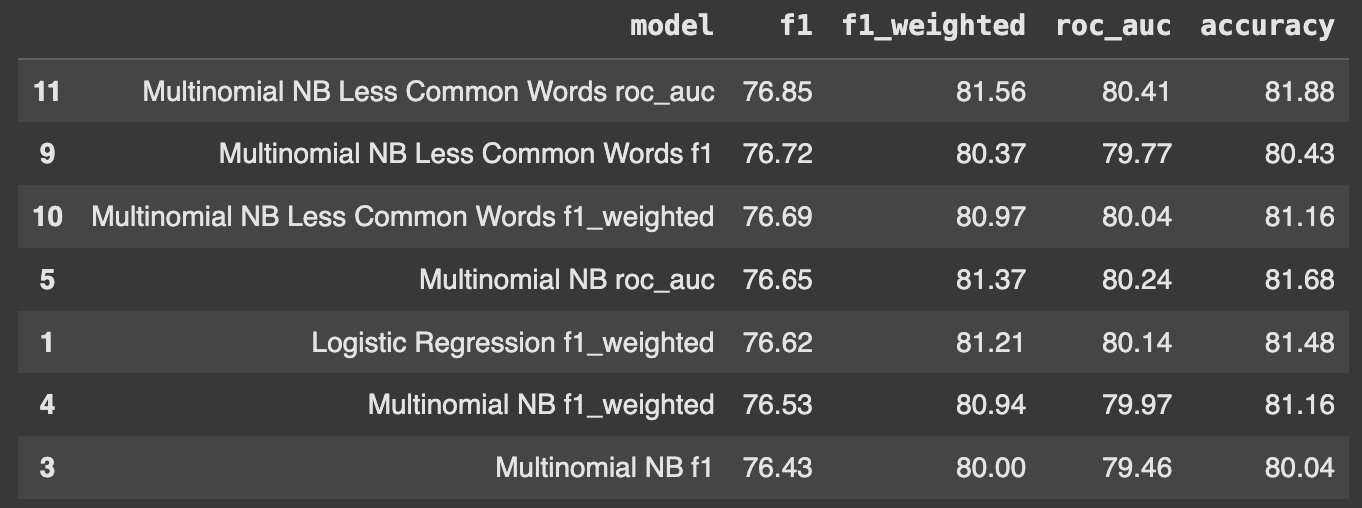

In [ ]:
for scoring in scoring_functions:
  my_X_train = X_train_reduced
  my_X_test = X_test_reduced
  my_y_train = y_train
  my_y_test = y_test

  model = MultinomialNB()

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'Multinomial NB Less Common Words {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Hyperparameters: {'model__alpha': 0.5, 'model__fit_prior': False, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
-----Multinomial NB Less Common Words f1-----
Training Confusion Matrix:
 [[3149  324]
 [ 456 2161]]
Testing Confusion Matrix:
 [[734 135]
 [163 491]]
Accuracy: Test 80.43  -  87.19 Train
ROC AUC: Test 79.77  -  86.62 Train
F1-score: Test 76.72  -  84.71 Train
Weighted F1-score: 80.37  -  87.15 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.91      0.89      3473
           1       0.87      0.83      0.85      2617

    accuracy                           0.87      6090
   macro avg       0.87      0.87      0.87      6090
weighted avg       0.87      0.87      0.87      6090

Test Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.84      0.83      

In [ ]:
df_summary = model_summaries(['Multinomial NB Less Common Words f1',
                   'Multinomial NB Less Common Words f1_weighted',
                   'Multinomial NB Less Common Words roc_auc',
                   'Multinomial NB f1',
                   'Multinomial NB f1_weighted',
                   'Multinomial NB roc_auc',
                   'Logistic Regression f1_weighted'])

df_summary

,model,f1,f1_weighted,roc_auc,accuracy
14,Multinomial NB Less Common Words roc_auc,76.85,81.56,80.41,81.88
12,Multinomial NB Less Common Words f1,76.72,80.37,79.77,80.43
13,Multinomial NB Less Common Words f1_weighted,76.69,80.97,80.04,81.16
5,Multinomial NB roc_auc,76.65,81.37,80.24,81.68
1,Logistic Regression f1_weighted,76.62,81.21,80.14,81.48
4,Multinomial NB f1_weighted,76.53,80.94,79.97,81.16
3,Multinomial NB f1,76.43,80.00,79.46,80.04


## XGBoost Classifier

After removing the common words, the grid search produced XGBoost models that performed identically regardless of the scoring function for optimization. However, doing so did not improve model performance above the best XGBoost variant.

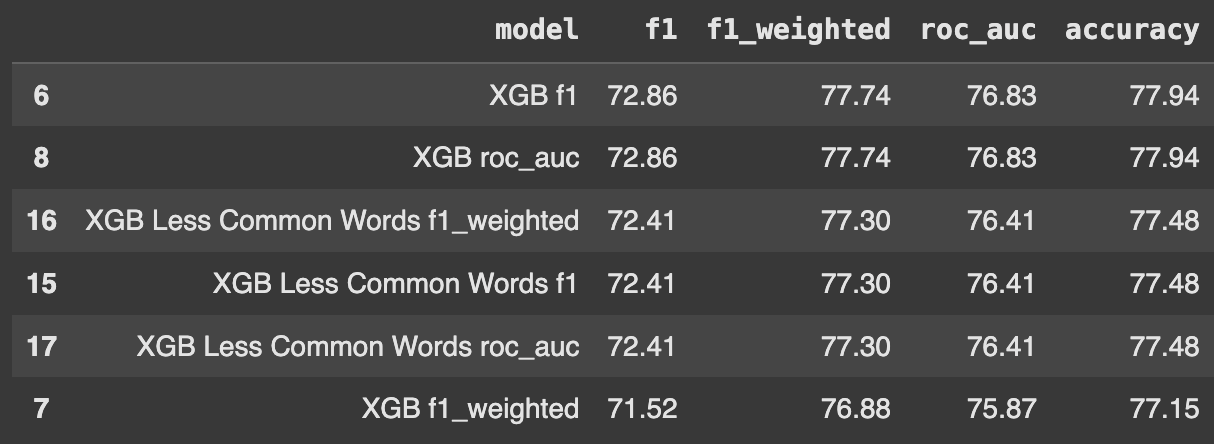

In [ ]:
for scoring in scoring_functions:
  my_X_train = X_train_reduced
  my_X_test = X_test_reduced
  my_y_train = y_train
  my_y_test = y_test

  model = XGBClassifier()

  param_grid = get_param_grid(model)
  pipeline = create_pipeline(model)
  ispca = False
  n_components = 0

  best_model, my_X_train, my_X_test, \
  my_y_train, my_y_test, best_params,  = train_model(pipeline,
                                          my_X_train, my_y_train,
                                          my_X_test, my_y_test,
                                          param_grid, ispca,
                                          n_components, scoring)

  evaluate_model(best_model, my_X_train, my_y_train, my_X_test, my_y_test,
                best_params, f'XGB Less Common Words {scoring}')

#true negatives 0,0     false positives 0, 1
#false negatives 1,0    true positives 1,1

Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best Hyperparameters: {'model__n_estimators': 500, 'tfidf__max_df': 0.8, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 1)}
-----XGB Less Common Words f1-----
Training Confusion Matrix:
 [[3412   61]
 [ 339 2278]]
Testing Confusion Matrix:
 [[730 139]
 [204 450]]
Accuracy: Test 77.48  -  93.43 Train
ROC AUC: Test 76.41  -  92.64 Train
F1-score: Test 72.41  -  91.93 Train
Weighted F1-score: 77.3  -  93.37 Train
Training Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94      3473
           1       0.97      0.87      0.92      2617

    accuracy                           0.93      6090
   macro avg       0.94      0.93      0.93      6090
weighted avg       0.94      0.93      0.93      6090

Test Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.84      0.81       869
           1       0.76    

In [ ]:
df_summary = model_summaries(['XGB Less Common Words f1',
                   'XGB Less Common Words f1_weighted',
                   'XGB Less Common Words roc_auc',
                   'XGB f1',
                   'XGB f1_weighted',
                   'XGB roc_auc',])


df_summary

,model,f1,f1_weighted,roc_auc,accuracy
6,XGB f1,72.86,77.74,76.83,77.94
8,XGB roc_auc,72.86,77.74,76.83,77.94
16,XGB Less Common Words f1_weighted,72.41,77.30,76.41,77.48
15,XGB Less Common Words f1,72.41,77.30,76.41,77.48
17,XGB Less Common Words roc_auc,72.41,77.30,76.41,77.48
7,XGB f1_weighted,71.52,76.88,75.87,77.15


# Summary of All Models

In [ ]:
df_summary_all = model_summaries()
df_summary_all

,model,f1,f1_weighted,roc_auc,accuracy
14,Multinomial NB Less Common Words roc_auc,76.85,81.56,80.41,81.88
12,Multinomial NB Less Common Words f1,76.72,80.37,79.77,80.43
13,Multinomial NB Less Common Words f1_weighted,76.69,80.97,80.04,81.16
5,Multinomial NB roc_auc,76.65,81.37,80.24,81.68
1,Logistic Regression f1_weighted,76.62,81.21,80.14,81.48
4,Multinomial NB f1_weighted,76.53,80.94,79.97,81.16
3,Multinomial NB f1,76.43,80.00,79.46,80.04
0,Logistic Regression f1,76.38,80.22,79.54,80.30
9,Logistic Regression Less Common Words f1,76.26,80.09,79.43,80.17
11,Logistic Regression Less Common Words roc_auc,75.40,80.52,79.32,80.89


# Save Models

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [66]:
save_path = '/content/drive/MyDrive/Masterschool_NLP_LLM/'

In [ ]:
import pickle

filename = 'model_comparisons.pkl'

with open(save_path + filename, 'wb') as f:
  pickle.dump(model_comparisons, f)

# Reload Models

In [ ]:
import pickle

with open(save_path + filename, 'rb') as f:
    model_comparisons = pickle.load(f)

